# Notebook setup

In [58]:
import pandas as pd
import numpy as np
import FCPython as fc 
import seaborn as sns
import matplotlib.pyplot as plt
import math


#Visualization
from matplotlib.patches import Arc
from matplotlib.collections import PathCollection
from matplotlib.legend_handler import HandlerPathCollection
#Model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
#Metric
from sklearn.metrics import r2_score, roc_auc_score, roc_curve

plt.rcParams["figure.figsize"] = (5,5)
random_state = 45

# Utilities

In [59]:
def compute_distance(
    x: float,
    y: float, 
    length: float,
    width: float) -> float:
    """
        Compute the distace from the center of the goal
        
        Inputs:
        - x: x coordinate in the interval [0,100],
        represents the x coordinate in % of the field
        - y: y coordinate in the interval [0,100],
        represents the y coordinate in % of the field
        - length: length of the pitch in meters
        - width: width of the pitch in meters
        
        Outputs:
        Distance in meters from the center of the goal
    """
    #Compute the distnace from the goal line
    # and map it into the interval [0, length]
    xc = (100-x)*length/100
    #Compute the distance from the middle of the field
    # and map it within the interval [0, width]
    yc = (50-y)*width/100
    #Return  the euclidean distance from the center
    # of the goal 
    return np.sqrt( xc**2 + yc**2 )



def carnot(
    x: float,
    y: float, 
    length: float,
    width: float) -> float:
    """
        Compute the angle of shot using the carnot theorem:
        cos \theta = ( a^2 + b^2 - c^2 ) / 2ab
        c = standard goal width = 7.32 m
        
        Inputs:
        - x: x coordinate in the interval [0,100],
        represents the x coordinate in % of the field
        - y: y coordinate in the interval [0,100],
        represents the y coordinate in % of the field
        - length: length of the pitch in meters
        - width: width of the pitch in meters
        
        Outputs:
        Shot angle 
    """
    #Compute the distnace from the goal line
    # and map it into the interval [0, length]
    xc = (100-x)*length/100
    #Compute the distance from the middle of the field
    # and map it within the interval [0, width]
    yc = (50-y)*width/100 
    #Compute a^2, b^2 and c^2
    a2 = (yc-7.32/2)**2 + xc**2
    b2 = (yc+7.32/2)**2 + xc**2
    c2 = 7.32**2
    #Return the angle
    return math.acos( (a2+b2-c2) / (2*np.sqrt(a2)*np.sqrt(b2) ))

In [60]:
def r2_adj_score(
    r2:float,
    n: int,
    p: int) -> float:
    """
        Compute the R2 adjusted score
        
        Inputs:
        - r2: r2 score computed on y_test and y_pred
        - n : number of samples used to train the model
        - p : number of predictors used to train the model
    """
    return 1-(1-r2)*(n-1)/(n-p-1)

In [61]:
def plot_roc_curve(y_test, y_pred):
    """
        Compute and plot the roc curve
        
        Inputs:
        - y_test : 1-D array containing the value to predict
        - y_pred : 1-D array containing the predicted values
    """
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred)
    # plot the roc curve for the model
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # plot the roc curve for a random guesser
    plt.plot([0,1], [0,1], linestyle='dotted', color='black', label = 'Random Guesser')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

def update(handle, orig):
    """
        Utility function for the legend
    """
    handle.update_from(orig)
    handle.set_alpha(1)

In [62]:
def createPitch(
    length: int =100,
    width: int =100,
    linecolor: str = 'black'
    ):
    """
        Create a football pitch
        
        This function is adaptation of 
        https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/FCPython.py
    """
    #Create figure
    fig=plt.figure()
    #fig.set_size_inches(7, 5)
    ax=fig.add_subplot(1,1,1)

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,width], color=linecolor)
    plt.plot([0,length],[width,width], color=linecolor)
    plt.plot([length,length],[width,0], color=linecolor)
    plt.plot([length,0],[0,0], color=linecolor)
    plt.plot([length/2,length/2],[0,width], color=linecolor)

    #Left Penalty Area
    plt.plot([16.5 ,16.5],[(width/2 +16.5),(width/2-16.5)],color=linecolor)
    plt.plot([0,16.5],[(width/2 +16.5),(width/2 +16.5)],color=linecolor)
    plt.plot([16.5,0],[(width/2 -16.5),(width/2 -16.5)],color=linecolor)

    #Right Penalty Area
    plt.plot([(length-16.5),length],[(width/2 +16.5),(width/2 +16.5)],color=linecolor)
    plt.plot([(length-16.5), (length-16.5)],[(width/2 +16.5),(width/2-16.5)],color=linecolor)
    plt.plot([(length-16.5),length],[(width/2 -16.5),(width/2 -16.5)],color=linecolor)

    #Left 5-meters Box
    plt.plot([0,5.5],[(width/2+7.32/2+5.5),(width/2+7.32/2+5.5)],color=linecolor)
    plt.plot([5.5,5.5],[(width/2+7.32/2+5.5),(width/2-7.32/2-5.5)],color=linecolor)
    plt.plot([5.5,0.5],[(width/2-7.32/2-5.5),(width/2-7.32/2-5.5)],color=linecolor)

    #Right 5 -eters Box
    plt.plot([length,length-5.5],[(width/2+7.32/2+5.5),(width/2+7.32/2+5.5)],color=linecolor)
    plt.plot([length-5.5,length-5.5],[(width/2+7.32/2+5.5),width/2-7.32/2-5.5],color=linecolor)
    plt.plot([length-5.5,length],[width/2-7.32/2-5.5,width/2-7.32/2-5.5],color=linecolor)

    #Prepare Circles
    centreCircle = plt.Circle((length/2,width/2),9.15,color=linecolor,fill=False)
    centreSpot = plt.Circle((length/2,width/2),0.8,color=linecolor)
    leftPenSpot = plt.Circle((11,width/2),0.8,color=linecolor)
    rightPenSpot = plt.Circle((length-11,width/2),0.8,color=linecolor)

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    #Prepare Arcs
    leftArc = Arc((11,width/2),height=18.3,width=18.3,angle=0,theta1=308,theta2=52,color=linecolor)
    rightArc = Arc((length-11,width/2),height=18.3,width=18.3,angle=0,theta1=128,theta2=232,color=linecolor)

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)
    
    #Tidy Axes
    #plt.axis('off')
    
    return fig,ax

# Import the data

In [63]:
#Read the data
df = pd.read_excel('shots_for_xg_model.xlsx')
#Plot the shape and the first 5 records
print(f'Shape: {df.shape}')
df.head()

Shape: (50000, 17)


,period_id,min,sec,x,y,volley,first_touch,head,left_footed,right_footed,1_on_1,regular_play,penalty,free_kick,set_piece,from_corner,is_goal
0,1,4,26,73.2,21.9,False,True,False,False,True,False,True,False,False,False,False,False
1,1,8,8,73.3,27.7,False,False,False,False,True,False,True,False,False,False,False,False
2,1,13,24,70.9,49.1,False,False,False,True,False,False,True,False,False,False,False,False
3,1,11,40,74.7,32.4,False,False,False,True,False,False,False,False,True,False,False,False
4,1,19,11,72.3,36.6,False,True,False,True,False,False,False,False,False,False,True,False


The dataset is composed by 17 columns and 5000 events. The columns are listed below:

* **period_id** : 1 if the shot has occured in the first half, otherwise 2
* **min** : inidcates the minute in wich the shot has occured
* **sec** : inidcates the second in wich the shot has occured
* **x** : x coordinate of the shot
* **y** : y coordinate of the shot
* **volley** : indicates whether the ball was hit on the volley.
* **first_touch** : indicates whether the shot was the first touch.
* **head** : indicates whether the shot was performed with the head
* **right_foot** : indicates whether the shot was performed with the right foot.
* **left_foot** : indicates whether the shot was performed with the left foot.
* **1_on_1** : indicates whether the offender was in a 1-on-1 situation with the goalkeeper.
* **regular_play** : indicates whether the action was not from a dead ball.
* **penalty** : indicates whether the shot was a penalty
* **free_kick** : indicates whether the shot was a free kick.
* **set_piece** : indicates whether the shot came from a set piece.
* **from_corner** : indicates whether the situation came from a corner.
* **is_goal** : indicates whether the shot genereted a goal.


By intuition we can assume that the first three columns would not affect the xG, since the likelihood of scoring is not related to playing time. 

The target columns will be *is_goal*. However, we have to consider that the xG of a shot is within the interval [0,1] and it is not a discrete variable, so it is necessary to find a strategy to evaluate the goodness of the model.

# Data Exploration

In [64]:
#Check missing values
np.sum(df.isna(), axis = 0)

period_id       0
min             0
sec             0
x               0
y               0
volley          0
first_touch     0
head            0
left_footed     0
right_footed    0
1_on_1          0
regular_play    0
penalty         0
free_kick       0
set_piece       0
from_corner     0
is_goal         0
dtype: int64

There aren't missing values

In [65]:
#Convert the columns from volley to is_goal in integer
df.loc[:,'volley': 'is_goal'] = df.loc[:,'volley':'is_goal'].astype(int)

In [66]:
df.describe()

,period_id,min,sec,x,y,volley,first_touch,head,left_footed,right_footed,1_on_1,regular_play,penalty,free_kick,set_piece,from_corner,is_goal
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000
mean,1.569080,49.366520,29.400520,84.687972,50.476090,0.100740,0.474300,0.170680,0.319360,0.506660,0.011260,0.69510,0.018160,0.042660,0.060480,0.14608,0.104180
std,0.563058,26.840778,17.377921,7.823852,12.808797,0.300987,0.499344,0.376233,0.466233,0.499961,0.105515,0.46037,0.133531,0.202091,0.238376,0.35319,0.305497
min,1.000000,0.000000,0.000000,30.600000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,27.000000,14.000000,78.200000,41.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,2.000000,50.000000,29.000000,86.400000,50.100000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,2.000000,72.000000,44.000000,90.900000,59.800000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.00000,0.000000
max,5.000000,130.000000,59.000000,99.900000,98.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000


Both x and y are in the interval [0,100], so they are normalized with respect to the pitch dimension. Moreover, since the the 2nd quintile of the x column is 86.4 we should assume that the offendant attack from left to right, i.e. the higher the x the nearer to the goal.

# Feature Analysis

In this section an analysis of the features is performed to better understand how the single features are related to the target variable.

First remove the time columns

In [67]:
df = df.drop(columns=['period_id', 'min', 'sec'])

In [68]:
#Compute the linear correlation between
# the features and the target variable
df.corr().loc[:, 'is_goal'].sort_values()

regular_play   -0.058842
from_corner    -0.029275
free_kick      -0.028578
set_piece      -0.015940
left_footed    -0.013136
volley         -0.011910
head           -0.009061
y              -0.002333
right_footed    0.018438
first_touch     0.043446
1_on_1          0.090803
x               0.210902
penalty         0.291428
is_goal         1.000000
Name: is_goal, dtype: float64

It seems that any of the features are highly correlated to the target feature. Indeed, only $|\rho(x, is\_goal)|$ and $|\rho(penalty, is\_goal)|$ are higher than 0.2. This was to be expected since, with the exception of the spatial coordinates (x,y), the others contain values {0,1} and thus no correlation with the target variable can be defined. Regarding the penalty column, however, it is normal that there is some semblance of correlation since most penalties are turned into goals.

<AxesSubplot:xlabel='head', ylabel='is_goal'>

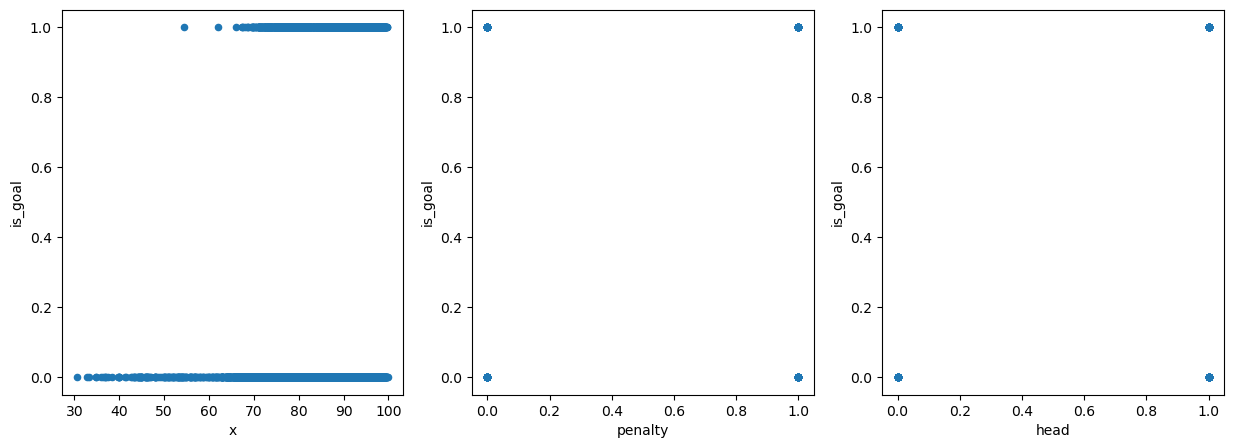

In [69]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
df.plot(x='x', y='is_goal', kind='scatter', ax = axs[0])
df.plot(x='penalty', y='is_goal', kind='scatter', ax = axs[1], alpha = 0.1)
df.plot(x='head', y='is_goal', kind='scatter', ax = axs[2])

### From where are the shots taken?

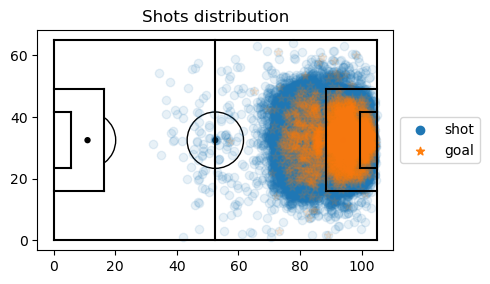

In [70]:
goals_only=df.loc[df['is_goal']==1].copy()

#Scatter plot
(fig,ax) = createPitch(105,65)
ax.scatter(df['x']*105/100, df['y']*65/100, alpha = 0.1, label = 'shot')
ax.scatter(goals_only['x']*105/100, goals_only['y']*65/100, marker = '*', label = 'goal', alpha = 0.1)
ax.set_title('Shots distribution')
plt.legend(handler_map={PathCollection : HandlerPathCollection(update_func= update)},
          loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Some shots are taken behind the middle line.

As expected the goals are concentrated around the penalty area. However, there are shots that led to the goal from a great distance.

### Goal distribution with respect to the conclusion type

In [71]:
#Since we do not know who shot, and so the prefered foot,
# we can considered left_footed and right_footed as a single column footed
df['footed'] = df['left_footed']+df['right_footed']
goals_only['footed'] = goals_only['left_footed']+goals_only['right_footed']

<AxesSubplot:title={'center':'Conclusion type distribution'}>

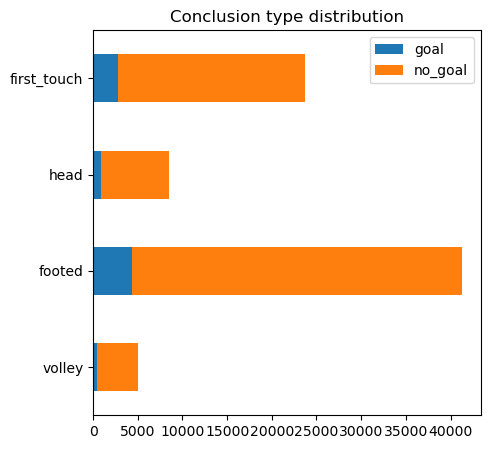

In [72]:
conclusion_types = ['volley', 'footed', 'head', 'first_touch']
#Count the total number of shots
# for each conclusion type
shots = df[conclusion_types].sum(axis=0)
shots.name = 'shots'
#Count the total number of goal
# for each conclusion type
goal = goals_only[conclusion_types].sum(axis=0)
goal.name = 'goal'
#Count the total number of no-goal
# for each conclusion type
no_goal = shots-goal
no_goal.name = 'no_goal'

#Concatenate the two computed pandas Series
df_ct = pd.concat(
    [goal.to_frame(), no_goal.to_frame()],
    axis = 1
)
#Construct the bar plot
df_ct.plot.barh(stacked='True', title = 'Conclusion type distribution')

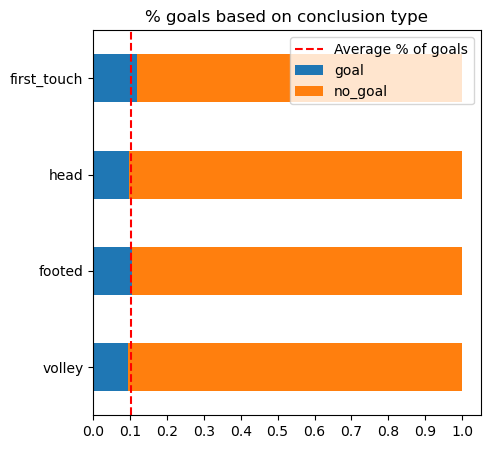

In [73]:
#100% STACKED BAR PLOT
#Compute the % of the two classes
df_ct_norm = (df_ct.T / df_ct.sum(axis = 1))
#Compute the % of goal considering all the conclusion types
goal_perc = df_ct_norm.loc['goal',:].mean()
#Construct the 100% stacked bar plot
ax = df_ct_norm.T.plot.barh(stacked='True', title='% goals based on conclusion type')
ax.axvline(x = goal_perc, c='red', linestyle='--', label='Average % of goals')
ax.set_xticks(np.linspace(0,1,11))
plt.legend()
plt.show()

From this first analysis we can observe how the percentage of shots converted into goals is quite indipendent from the conclusion type. Indeed, we have about 10% of goal shot in each category. This is not completly unexpected since the correlation coefficient is in the interval [-0.02,0.05] for all the conclusion types.
Based on this consideration we can say that a shot has an **xG of 0.1** no metter the position and how the play is originated.

### Goal distribution with respect to the play type

<AxesSubplot:title={'center':'Play type distribution'}>

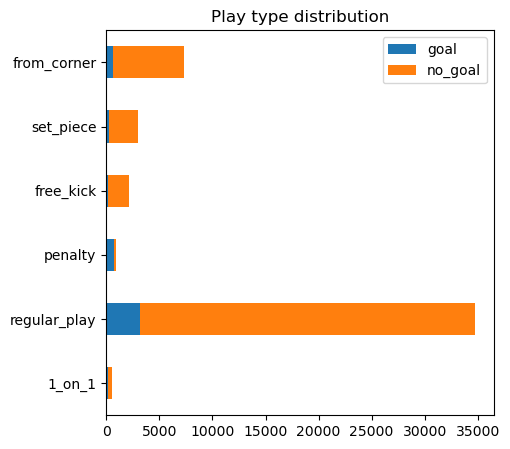

In [74]:
play_type = ['1_on_1','regular_play','penalty','free_kick','set_piece','from_corner']
#Count the total number of shots
# for each play type
shots = df[play_type].sum(axis=0)
shots.name = 'shots'
#Count the total number of goal
# for each play type
goal = goals_only[play_type].sum(axis=0)
goal.name = 'goal'
#Count the total number of no_goal
# for each play type
no_goal = shots-goal
no_goal.name = 'no_goal'

#Concatenate the two computed pandas Series
df_pt = pd.concat(
    [goal.to_frame(), no_goal.to_frame()],
    axis = 1
)
#Construct the bar plot
df_pt.plot.barh(stacked='True', title = 'Play type distribution')

           1_on_1  regular_play   penalty  free_kick  set_piece  from_corner
goal     0.364121      0.092274  0.758811   0.062822   0.084987     0.082558
no_goal  0.635879      0.907726  0.241189   0.937178   0.915013     0.917442


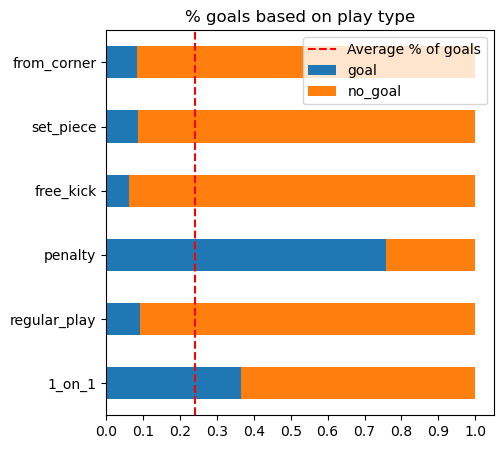

In [75]:
#100% STACKED BAR PLOT
#Compute the % of the two classes
df_pt_norm = (df_pt.T / df_pt.sum(axis = 1))
#Compute the % of goal considering all the play types
goal_perc = df_pt_norm.loc['goal',:].mean()
print(df_pt_norm)
#Construct the 100% stacked bar plot
ax = df_pt_norm.T.plot.barh(stacked='True', title='% goals based on play type')
ax.axvline(x = goal_perc, c='red', linestyle='--', label='Average % of goals')
ax.set_xticks(np.linspace(0,1,11))
plt.legend()
plt.show()

With repsect to the goal distribution based on conclusion type, now we have a more intersting situtation. Indeed not all the play type lead to a similiar % of goals. As we could image the percentage of goals coming from the penalties is very high (about 76%) and also the the 1on1 stituation lead to an high percentage of goals (about 36%). Instead, if we consider the other play types, the % of goals drops to about 8% on average.

### Feature analysis conclusion

Through an initial analysis of the data, we can affirm that:
* The xG should not be correlated to the conclusion type;
* The xG should be affected by the play type, in particular if the shot comes from a 1on1 situation;
* We may need new feature such as distance and angle to better describe the shot event.

In the next steps we will consider only the non penalty shots, since we already know the xG for a penalty and it is 0.758.

In [76]:
np_df = df.loc[df.penalty==0, :].copy()
f'No penalty events: {len(np_df)}'

'No penalty events: 49092'

# Feature Engineering

In this section new metric to better describe the shot event are created.

In [77]:
#Standard pitch dimension
length = 105
width = 65

### Distance to the goal

Given the (x,y) coordinate is possible to retrive the distance with repsect to the centre of the goal.

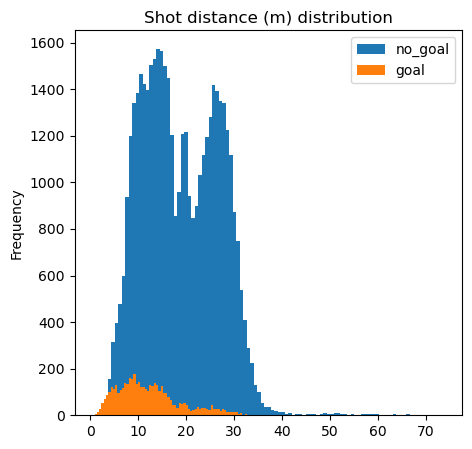

In [78]:
np_df['distance'] = np_df[['x','y']].apply(lambda shot: compute_distance(shot.x,shot.y, length, width), axis=1)
np_df.groupby(by='is_goal')['distance'].plot(kind='hist', bins = 100, title = 'Shot distance (m) distribution')
plt.legend(labels= ['no_goal', 'goal'])

The goals are mainly concentrated in the first 30 meters. This respect the observation made in the section 'From where are the shots taken?'.

### Angle

The angle metric indicates the angle of the vertex of the cone built on the the position of the player and the goal posts. 

In [79]:
# import image module
from IPython.display import Image
  
# get the image
Image(url="https://static.capabiliaserver.com/frontend/clients/barca/wp_prod/wp-content/uploads/2022/05/37ce0e8c-foto.jpg")

To compute the angle the Carnot theorem is used:
$$ cos(\gamma) = \frac{a^2+b^2-c^2}{2ab} $$
where $a$ is the distance between the shot position (x,y) and the lower post, $b$ is the distance between the shot position (x,y) and the higher post, $c$ is the goal mouth width set to 7.32.

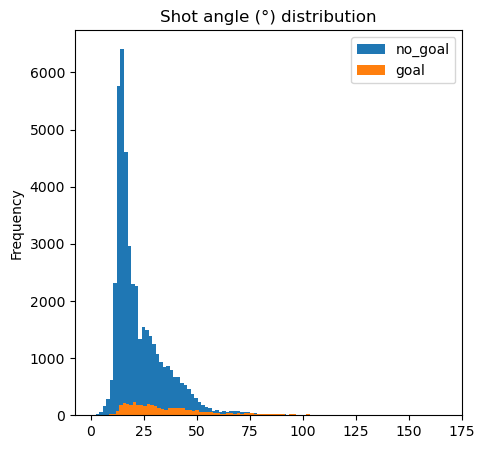

In [80]:
np_df['radians'] = np_df[['x','y']].apply(lambda shot: carnot(shot.x,shot.y, length, width), axis=1)
np_df['degree'] = np_df['radians']*180/math.pi
np_df.groupby(by='is_goal')['degree'].plot(kind='hist', bins = 100, title = 'Shot angle (°) distribution')
plt.legend(labels= ['no_goal', 'goal'])

In [81]:
np_df.corr()['is_goal']

x               0.204753
y              -0.000917
volley          0.001447
first_touch     0.086845
head            0.009529
left_footed    -0.004031
right_footed   -0.004416
1_on_1          0.101347
regular_play    0.001090
penalty              NaN
free_kick      -0.021561
set_piece      -0.006279
from_corner    -0.013758
is_goal         1.000000
footed         -0.010714
distance       -0.234591
radians         0.308026
degree          0.308026
Name: is_goal, dtype: float64

The angle is the feature with the highest correlation ratio with the target variable.

Based on the observations made above, for a baseline xG model we can choose the following features:
* distance
* angle (randians or degree)

Then we could insert the other features step by step, to check if a more complete description of the shot event could help the model for the xG estimation.

# Model

In this section we will test a LogisticRegression model, adding step by step new features. The different versions will be compared on the $R^2$ (also called *coefficient of determination*) and $\hat R^2 adjusted$ metrics computed as:

$$R^2 = 1 - \frac{RSS}{TSS}$$

$$\hat R^2 = 1-(1-R^2) \frac{n-1}{n-p-1}$$

where $RSS$ is the residual sum of errors, $TSS$ is the total sum of errors, $n$ is the number of samples, and $p$ is the number of predictors (features) used. The $\hat R^2$ allows to compare regression models with a different number of predictors and it is better than the $R^2$ since it increases only if the new predictors improve the model.

The use of a LogisticRegression is due to the outcomes that we want from our model. Indeed, we are trying to compute probabilites, i.e. values within the interval [0,1], but a simple LinearRegression model could return values in the interval [-inf, inf].


## Base non-penalty xG models

A first version of the xG model could be built only on the features distance and angle since they are the more correlated ones to the target variable.

In [82]:
features = ['distance', 'radians']
#Remove the penalties from the dataset
X, y = np_df[features], np_df['is_goal']
print(y.value_counts(normalize = True))
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle = True, stratify=y, random_state = random_state)
print(y_train.value_counts(normalize = True))
X_train.head()

0    0.907928
1    0.092072
Name: is_goal, dtype: float64
0    0.907928
1    0.092072
Name: is_goal, dtype: float64


,distance,radians
3351,21.796817,0.313884
41404,24.495144,0.256283
1461,14.046909,0.481386
27427,10.336088,0.678459
2103,10.965059,0.548834


Since the shot outcomes are unbalanced it is important to set *stratify = True* in the *train_test_split* function to avoid that the model fits on different distribution with repsect to the reality.

In [83]:
#Create the model
model = make_pipeline(StandardScaler(), LogisticRegression(random_state = random_state))
#Fit the model
model.fit(X_train, y_train)
#Preidct probabilities
y_pred = model.predict_proba(X_test)[:,1]
#Compute the r2 and r2_adj score
r2 = r2_score(y_test, y_pred)
n, p = X_train.shape
r2_adj = r2_adj_score(r2, n, p)

print(f"R^2 = {r2:.5f}\t R^2_adj = {r2_adj:.5f}")

R^2 = 0.10195	 R^2_adj = 0.10190


Logistic: ROC AUC=0.749


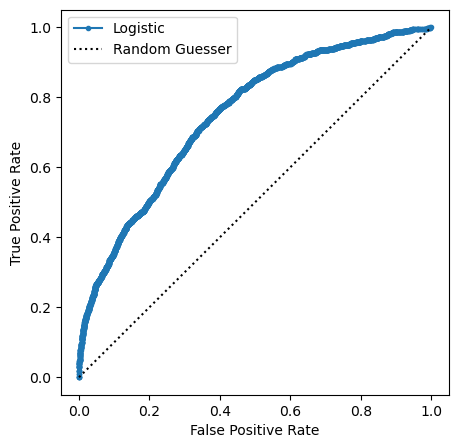

In [84]:
lr_auc = roc_auc_score(y_test, y_pred)
#Summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))
#Plot the roc curve
plot_roc_curve(y_test, y_pred)

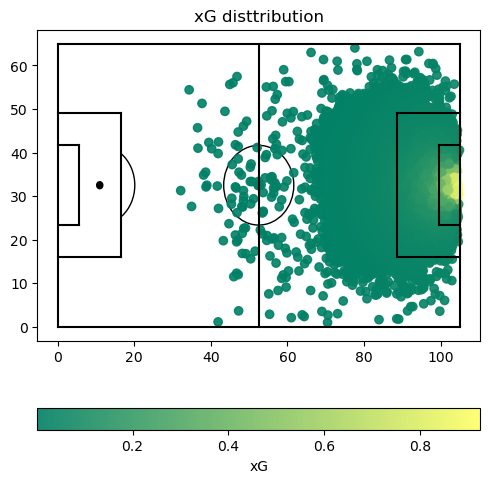

In [85]:
#Compute the xG for all the shots
np_df['xG'] = model.predict_proba(X)[:,1]
#Plot on the pitch the xG
fig, ax = createPitch(length,width)
s = ax.scatter(np_df['x']*length/100, np_df['y']*width/100, alpha= 0.9, c=np_df['xG'], cmap='summer')
ax.set_title('xG disttribution')
fig.colorbar(s, ax=ax, label = 'xG', orientation = 'horizontal')
plt.tight_layout()
plt.show()

The final outcome is reasonable good, indeed we can see how the xG is about 0.8 close the goal and rapidly drops to less then 0.2.

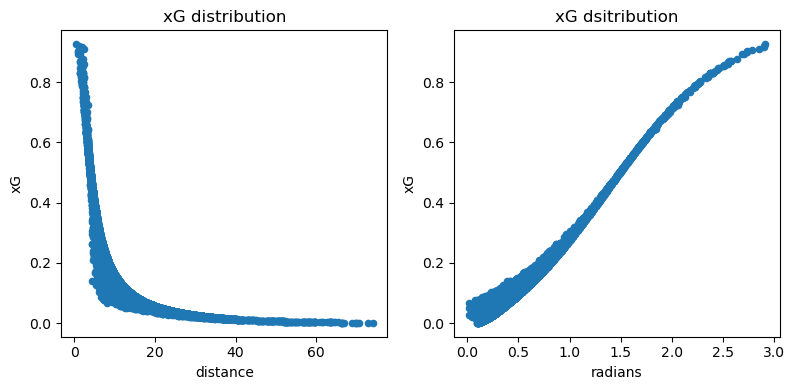

In [86]:
#xG distribution with respect to distance and angle
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
np_df.plot(x='distance', y='xG', kind='scatter', title='xG distribution', ax = ax1)
np_df.plot(x='radians', y='xG', kind='scatter', title= 'xG dsitribution', ax = ax2)
plt.tight_layout()

As was expected the xG drops is inversely proportional to the distance and directly proportional to the angle.

Since the xG seems to be quadratcly linked to the distance we can try to insert $distance^2$ as new predictor.

## Model extentions

Now that we have some reference result, we could try to insert other fetures to check if additional information such as th conclusion and play type could help the model to better estimate the xG. 

In [87]:
np_df['d2'] = np_df['distance']**2
features = ['distance', 'radians', 'd2']

X, y = np_df[features], np_df['is_goal']
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle = True, stratify=y, random_state = random_state)
X_train.head()

,distance,radians,d2
3351,21.796817,0.313884,475.101250
41404,24.495144,0.256283,600.012100
1461,14.046909,0.481386,197.315650
27427,10.336088,0.678459,106.834725
2103,10.965059,0.548834,120.232525


In [88]:
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:,1]

r2 = r2_score(y_test, y_pred)
n, p = X_train.shape
r2_adj = r2_adj_score(r2, n, p)

print(f"R^2 = {r2:.5f}\t R^2_adj = {r2_adj:.5f}")

R^2 = 0.10310	 R^2_adj = 0.10303


Both the R^2 and R^2_adj increased, this means that the predicotr $distance^2$ helps the model to better predict the xG.

In [89]:
lr_auc = roc_auc_score(y_test, y_pred)
#Summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))

Logistic: ROC AUC=0.750


Also the ROC AUC incerases.

Now we can try to add the $distance*angle$ predictor since when you are near the goal but you are defiled, the xG should be lower.

In [90]:
np_df['da'] = np_df['distance']*np_df['radians']
features = ['distance', 'radians', 'd2', 'da']

X, y = np_df[features], np_df['is_goal']
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle = True, stratify=y, random_state = random_state)


model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:,1]

r2 = r2_score(y_test, y_pred)
n, p = X_train.shape
r2_adj = r2_adj_score(r2, n, p)

print(f"R^2 = {r2:.5f}\t R^2_adj = {r2_adj:.5f}")

lr_auc = roc_auc_score(y_test, y_pred)
#Summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))

R^2 = 0.10303	 R^2_adj = 0.10293
Logistic: ROC AUC=0.750


The model does not improve, so we will not use the product $distance*angle$

Now we could try to pass as features also the conclusion type.

In [91]:
features = ['distance', 'radians', 'd2']+conclusion_types
X, y = np_df[features], np_df['is_goal']
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle = True, stratify=y, random_state = random_state)


model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:,1]

r2 = r2_score(y_test, y_pred)
n, p = X_train.shape
r2_adj = r2_adj_score(r2, n, p)

print(f"R^2 = {r2:.3f}\t R^2_adj = {r2_adj:.3f}")

lr_auc = roc_auc_score(y_test, y_pred)
#Summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))

R^2 = 0.123	 R^2_adj = 0.123
Logistic: ROC AUC=0.780


Knowing the conclusion type the model is able to increase the quality of the predictions. 

This seems to go against the thinking in the previous sections where we analyzed the correlation between conclusion type and % of goals realized, but thinking about it, it is not wrong that the accuracy of the model increases. In fact, at the same distance and angle a foot conclusion should guarantee a higher xG than a head conclusion.

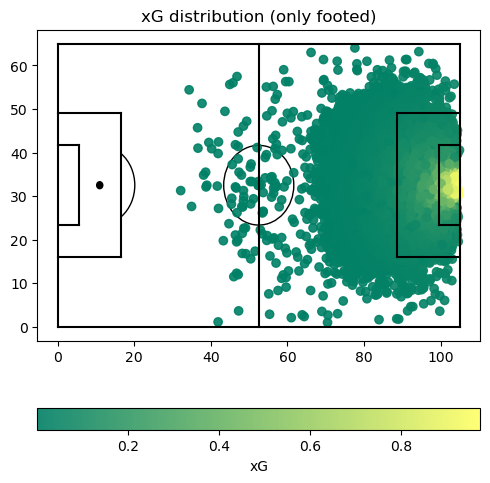

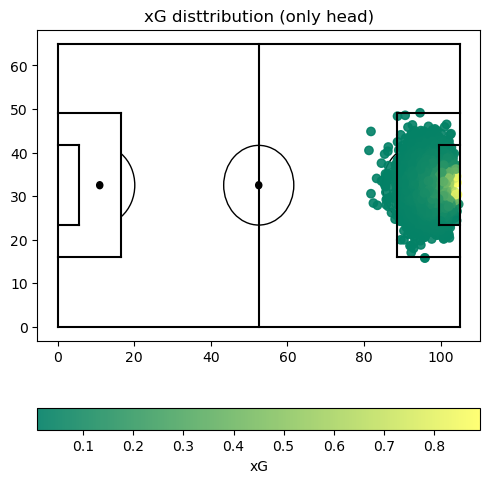

In [92]:
#Compute the xG for all the shots
np_df['xG'] = model.predict_proba(X)[:,1]
#Plot on the pitch the xG
footed = np_df.loc[np_df['footed'] == 1,:]
head = np_df.loc[np_df['head'] == 1,:]
#Plot only footed shot
fig, ax = createPitch(length,width)
s = ax.scatter(footed['x']*length/100, footed['y']*width/100, alpha= 0.9, c=footed['xG'], cmap='summer')
ax.set_title('xG distribution (only footed)')
fig.colorbar(s, ax=ax, label = 'xG', orientation = 'horizontal')
plt.tight_layout()
plt.show()
#Plot only head shot
fig, ax = createPitch(length,width)
s = ax.scatter(head['x']*length/100, head['y']*width/100, alpha= 0.9, c=head['xG'], cmap='summer')
ax.set_title('xG disttribution (only head)')
fig.colorbar(s, ax=ax, label = 'xG', orientation = 'horizontal')
plt.tight_layout()
plt.show()

Now let try to add also the play type.

In [93]:
#Prepare the dataset
features = ['distance', 'radians', 'd2']+conclusion_types+play_type
features.remove('penalty')
X, y = np_df[features], np_df['is_goal']
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle = True, stratify=y, random_state = random_state)

#train the model
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:,1]

#Compute the metrics
r2 = r2_score(y_test, y_pred)
n, p = X_train.shape
r2_adj = r2_adj_score(r2, n, p)

print(f"R^2 = {r2:.3f}\t R^2_adj = {r2_adj:.3f}")

lr_auc = roc_auc_score(y_test, y_pred)
print('Logistic: ROC AUC=%.3f' % (lr_auc))

R^2 = 0.137	 R^2_adj = 0.137
Logistic: ROC AUC=0.789


If we pass also the play type, the model further increase the prediction quality.

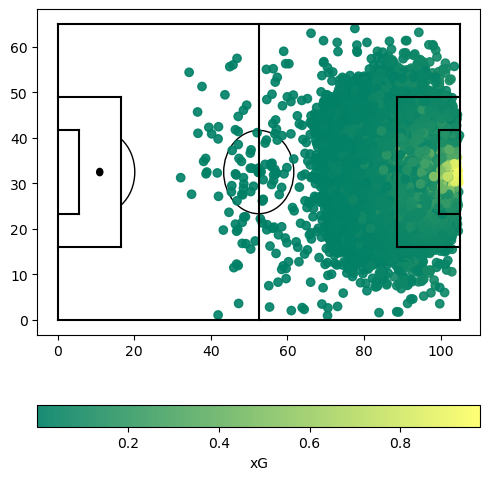

In [94]:
#Compute the xG for all the shots
np_df['xG'] = model.predict_proba(X)[:,1]
#Plot on the pitch the xG
fig, ax = createPitch(length,width)
s = ax.scatter(np_df['x']*length/100, np_df['y']*width/100, alpha= 0.9, c=np_df['xG'], cmap='summer')
fig.colorbar(s, ax=ax, label = 'xG', orientation = 'horizontal')
plt.tight_layout()
plt.show()

As shown in the figure above, we now have a higher xG in the entire penalty area than in the basic model.

# Conclusion

Passing to the model all the features, the xG estimation quality increase. Below the features are listed with the relative coefficients used by the model to predict the xG.

In [95]:
coef =  model['logisticregression'].coef_[0]
features = np.array(features)

In [96]:
print('Feature with a positive impact on xG')
list(zip(features[coef>0],coef[coef>0]))

Feature with a positive impact on xG


[('radians', 0.5301129309513719),
 ('footed', 0.3383357043452671),
 ('1_on_1', 0.1240961781212511),
 ('free_kick', 0.12521176231846654)]

In [97]:
print('Feature with a negative impact on xG')
list(zip(features[coef<0],coef[coef<0]))

Feature with a negative impact on xG


[('distance', -0.4511747615743198),
 ('d2', -0.33785219462714267),
 ('volley', -0.09462863383571236),
 ('head', -0.017001438054757),
 ('first_touch', -0.012649087605741929),
 ('regular_play', -0.22150821387288988),
 ('set_piece', -0.19728073843112015),
 ('from_corner', -0.3747214929456472)]

# Further works and improvements

In this notebook a default LogisticRegression model is used to analyze the xG of a shot event considering distance to the goal, shot angle, conlcusion and play type. To improve the model we could try to fine tunining the hyperparameters of the model using first an *halving grid search* to explore a wider sample space and then a *grid search* in a neighborhood of the returned parameter set.

Another possible improvement could be the integration of additional information such as the number of opponents and their position within the shot cone or the position of the goalkeeper. Knowing also who take the shot, or at least his role, may be useful since a striker who shots with the preferred foot will have higher chances to score with respect to a defender who shots with the weak foot considering the same shooting conditions.

Finally, it is possible to try and test different model types. In literature, RandomForest, XGBoost (extreme gradiant descent boosting), and Neural Networks are used to predict the xG of a shot event. In that case we have to care about that the final output is a probability an so it is contained within the interval [0,1].